## Final Project Submission

Please fill out:
* Student name: Stephen Gomes
* Student pace: self paced 
* Scheduled project review date/time: 2022.10.26 15:00
* Instructor name: Joe Comeaux
* Blog post URL: #TODO


In [1]:
# Your code here - remember to use markdown cells for comments as well!

# setup all our imports 
import json
import pandas as pd
import numpy as np
import matplotlib 
import sqlite3 
import requests
import matplotlib.pyplot as plt

%matplotlib inline

# clear some warnings on edits to copies of dataslice 
pd.options.mode.chained_assignment = None  # default='warn'



In [2]:
# main thesis - we don't care about reviews, we care about sales
# focussed on US market to start with, if successful expand globally 

In [3]:
# read in all our input files 
info = pd.read_csv('zippedData/rt.movie_info.tsv.gz', sep="\t") # USED
budgets = pd.read_csv('zippedData/tn.movie_budgets.csv.gz') # USED
# open DB file for query, get list of tables, USED
conn = sqlite3.connect('zippedData/im.db')
tbls = pd.read_sql("""SELECT name FROM sqlite_master WHERE type = 'table';""", conn)

# SUPPLIED INPUTS NOT USED BELOW
# reviews file had a utf8 encoding error with default pandas read encoding 
reviews = pd.read_csv('zippedData/rt.reviews.tsv.gz', sep="\t", encoding = "ISO-8859-1", engine='python') # not used
bom = pd.read_csv('zippedData/bom.movie_gross.csv.gz') # not used
tmdb = pd.read_csv('zippedData/tmdb.movies.csv.gz') # not used


In [4]:
tbls

,name
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


In [5]:
# select info from movie_basics table to enrich budgets with genre
movie_basics = pd.read_sql("""SELECT primary_title AS movie,start_year AS year,genres FROM movie_basics;""", conn)
conn.close()

In [6]:
# we need to adjust historical dollars to 2022 level, let's get CPI data from Fed
# webscrape directly with pandas & requests
# grab CPI of Minn. Fed site
html_page = requests.get('https://www.minneapolisfed.org/about-us/monetary-policy/inflation-calculator/consumer-price-index-1913-') # Make a get request to retrieve the page
webdf_list = pd.read_html(html_page.text) # pull the table from the html
webdf = webdf_list[0]
webdf

,Year,Annual Average CPI(-U),Annual Percent Change (rate of inflation)
0,1913,9.9,NaN
1,1914,10.0,1.3%
2,1915,10.1,0.9%
3,1916,10.9,7.7%
4,1917,12.8,17.8%
...,...,...,...
105,2018,251.1,2.4%
106,2019,255.7,1.8%
107,2020,258.8,1.2%
108,2021,271.0,4.7%


In [7]:
# cleanup CPI data 
# rename CPI column, remove inflation rate, create annual multiplier column which adjusts to 2022 $ values
cpi = webdf.rename({'Year' : 'year' , 'Annual Average CPI(-U)': 'CPI'}, axis=1)
cpi = cpi.iloc[: , :-1]
cpi['CPI_mult'] = cpi.iloc[-1]['CPI':].div(cpi.loc[:,'CPI':]).astype(np.float64)
# clean up current year * label, cast to int
cpi.loc[cpi['year'] == '2022*', 'year'] = '2022'
cpi['year'] = cpi['year'].astype(np.int64)
cpi

,year,CPI,CPI_mult
0,1913,9.9,29.737374
1,1914,10.0,29.440000
2,1915,10.1,29.148515
3,1916,10.9,27.009174
4,1917,12.8,23.000000
...,...,...,...
105,2018,251.1,1.172441
106,2019,255.7,1.151349
107,2020,258.8,1.137558
108,2021,271.0,1.086347


In [8]:
# cleanup budgets data
clean_budgets = budgets
clean_budgets['release_date'] = pd.to_datetime(clean_budgets['release_date'])
clean_budgets['year'] = clean_budgets['release_date'].dt.year
clean_budgets = clean_budgets.merge(movie_basics,on=['year','movie'],how='left')
clean_budgets = clean_budgets.loc[~clean_budgets['genres'].isnull()] 
# join CPI info & inflate $ to 2022 figures
clean_budgets = clean_budgets.merge(cpi, on='year', how='left')
clean_budgets["worldwide_gross"] = clean_budgets["worldwide_gross"].replace("[$,]", "", regex=True).astype(np.float64)
clean_budgets["production_budget"] = clean_budgets["production_budget"].replace("[$,]", "", regex=True).astype(np.float64)
clean_budgets['gross2022'] = clean_budgets['worldwide_gross'] * clean_budgets['CPI_mult']
clean_budgets['budget2022'] = clean_budgets['production_budget'] * clean_budgets['CPI_mult']
clean_budgets['net2022'] = clean_budgets['gross2022'] - clean_budgets['budget2022']
clean_budgets


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year,genres,CPI,CPI_mult,gross2022,budget2022,net2022
0,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,"$241,063,875",1.045664e+09,2011,"Action,Adventure,Fantasy",224.9,1.309026,1.368801e+09,5.374862e+08,8.313153e+08
1,3,2019-06-07,Dark Phoenix,350000000.0,"$42,762,350",1.497624e+08,2019,"Action,Adventure,Sci-Fi",255.7,1.151349,1.724288e+08,4.029722e+08,-2.305435e+08
2,4,2015-05-01,Avengers: Age of Ultron,330600000.0,"$459,005,868",1.403014e+09,2015,"Action,Adventure,Sci-Fi",237.0,1.242194,1.742816e+09,4.106694e+08,1.332146e+09
3,7,2018-04-27,Avengers: Infinity War,300000000.0,"$678,815,482",2.048134e+09,2018,"Action,Adventure,Sci-Fi",251.1,1.172441,2.401317e+09,3.517324e+08,2.049585e+09
4,9,2017-11-17,Justice League,300000000.0,"$229,024,295",6.559452e+08,2017,"Action,Adventure,Fantasy",245.1,1.201142,7.878836e+08,3.603427e+08,4.275409e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1536,45,2017-01-27,Emily,27000.0,"$3,547",3.547000e+03,2017,Drama,245.1,1.201142,4.260452e+03,3.243084e+04,-2.817039e+04
1537,49,2015-09-01,Exeter,25000.0,$0,4.897920e+05,2015,"Horror,Mystery,Thriller",237.0,1.242194,6.084167e+05,3.105485e+04,5.773619e+05
1538,52,2015-12-01,Dutch Kills,25000.0,$0,0.000000e+00,2015,"Crime,Drama,Thriller",237.0,1.242194,0.000000e+00,3.105485e+04,-3.105485e+04
1539,59,2011-11-25,The Ridges,17300.0,$0,0.000000e+00,2011,"Drama,Horror,Thriller",224.9,1.309026,0.000000e+00,2.264615e+04,-2.264615e+04


In [9]:
# cleanup info table to just non-null box office sales
# has genre, director, genre, runtime
clean_info = info.loc[(~info['box_office'].isnull()) & (info['currency']=='$')] 
clean_info['theater_date'] = pd.to_datetime(clean_info['theater_date'])
clean_info['year'] = clean_info['theater_date'].dt.year
clean_info['month'] = clean_info['theater_date'].dt.month

# join CPI info & inflate $ to 2022 figures
clean_info = clean_info.merge(cpi, on='year', how='left')
clean_info["box_office"] = clean_info["box_office"].replace("[$,]", "", regex=True).astype(np.float64)
clean_info['box2022'] = clean_info['box_office'] * clean_info['CPI_mult']
clean_info['runtime'] = clean_info['runtime'].replace("[minutes]", "", regex=True).astype(np.float64)

# map months to seasons
m2s = {1.0: "Winter", 2.0: "Winter", 3.0: "Spring", 4.0: "Spring", 5.0: "Spring", 6.0: "Summer", 7.0: "Summer", 8.0: "Summer", 9.0: "Fall", 10.0: "Fall", 11.0: "Fall", 12.0: "Winter"}
clean_info['season'] = clean_info['month'].map(m2s)
clean_info

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio,year,month,CPI,CPI_mult,box2022,season
0,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,2012-08-17,"Jan 1, 2013",$,600000.0,108.0,Entertainment One,2012.0,8.0,229.6,1.282230,7.693380e+05,Summer
1,10,Some cast and crew from NBC's highly acclaimed...,PG-13,Comedy,Jake Kasdan,Mike White,2002-01-11,"Jun 18, 2002",$,41032915.0,82.0,Paramount Pictures,2002.0,1.0,179.9,1.636465,6.714892e+07,Winter
2,13,"Stewart Kane, an Irishman living in the Austra...",R,Drama,Ray Lawrence,Raymond Carver|Beatrix Christian,2006-04-27,"Oct 2, 2007",$,224114.0,123.0,Sony Pictures Classics,2006.0,4.0,201.6,1.460317,3.272776e+05,Spring
3,14,"""Love Ranch"" is a bittersweet love story that ...",R,Drama,Taylor Hackford,Mark Jacobson,2010-06-30,"Nov 9, 2010",$,134904.0,117.0,NaN,2010.0,6.0,218.1,1.349840,1.820988e+05,Summer
4,22,Two-time Academy Award Winner Kevin Spacey giv...,R,Comedy|Drama|Mystery and Suspense,George Hickenlooper,Norman Snider,2010-12-17,"Apr 5, 2011",$,1039869.0,108.0,ATO Pictures,2010.0,12.0,218.1,1.349840,1.403656e+06,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,1980,A band of renegades on the run in outer space ...,PG-13,Action and Adventure|Science Fiction and Fantasy,Joss Whedon,Joss Whedon,2005-09-30,"Dec 20, 2005",$,25335935.0,119.0,Universal Pictures,2005.0,9.0,195.3,1.507424,3.819201e+07,Fall
336,1981,"Money, Fame and the Knowledge of English. In I...",NR,Comedy|Drama,Gauri Shinde,Gauri Shinde,2012-10-05,"Nov 20, 2012",$,1416189.0,129.0,Eros Entertainment,2012.0,10.0,229.6,1.282230,1.815880e+06,Fall
337,1985,A woman who joins the undead against her will ...,R,Horror|Mystery and Suspense,Sebastian Gutierrez,Sebastian Gutierrez,2007-06-01,"Oct 9, 2007",$,59371.0,98.0,IDP Distribution,2007.0,6.0,207.3,1.420164,8.431656e+04,Summer
338,1986,Aki Kaurismaki's The Man Without a Past opens ...,PG,Art House and International|Comedy|Drama,NaN,NaN,2002-08-30,"Oct 7, 2003",$,794306.0,97.0,NaN,2002.0,8.0,179.9,1.636465,1.299854e+06,Summer


In [10]:
# explode out multi-genre films to each of their component genres 
g2n = clean_budgets[['genres','net2022']]
g2n['genres']=g2n['genres'].apply(lambda x : x.split(','))
g2n = g2n.join(pd.concat([g2n.pop('genres').explode()],axis=1))

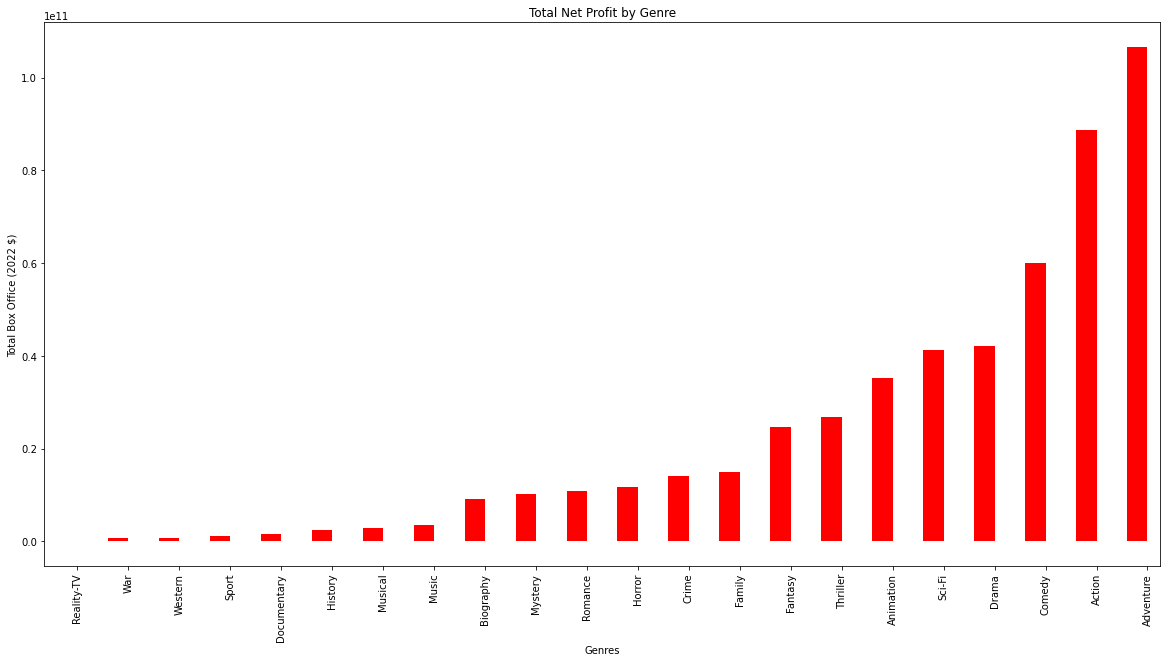

In [12]:
# visualize total box office sales by genre
tot_net = g2n[['genres','net2022']].groupby('genres').sum()
tot_net = tot_net.sort_values(by=['net2022'])
plt.rcParams['figure.figsize'] = (20, 10)
fig = plt.figure() # Create matplotlib figure
ax0 = fig.add_subplot(111) # Create matplotlib axes
width = 0.4
tot_net.net2022.plot(kind='bar', color='red', ax=ax0, width=width, position=1)
ax0.set_title('Total Net Profit by Genre')
ax0.set_xlabel('Genres')
ax0.set_ylabel('Total Box Office (2022 $)')
plt.show()

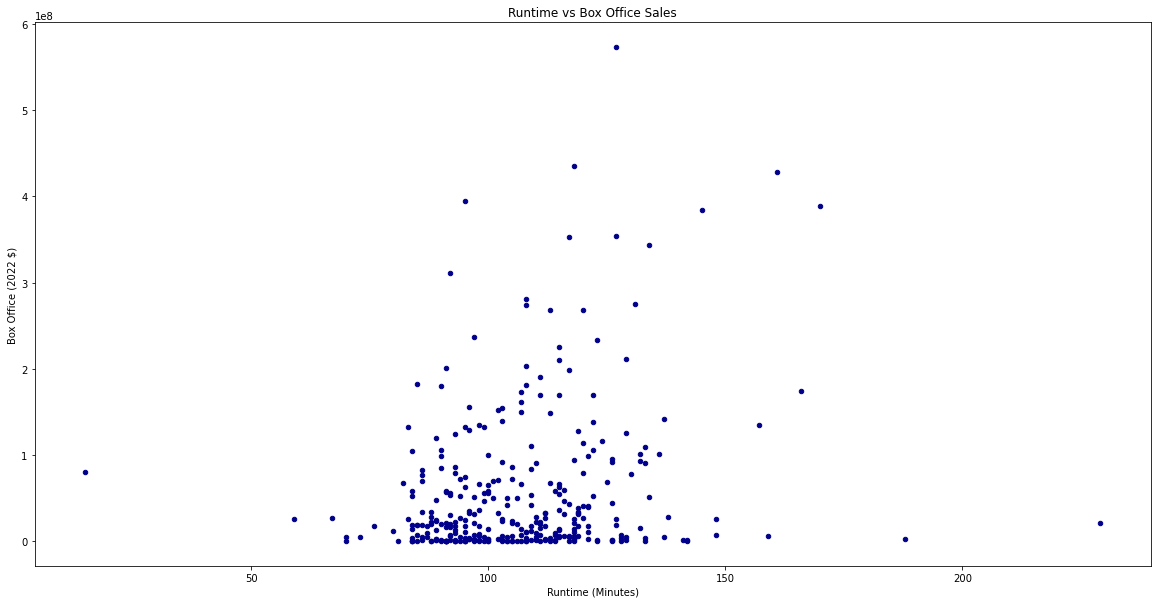

In [13]:
ax1 = clean_info.plot.scatter(x='runtime',y='box2022',c='DarkBlue')
ax1.set_title('Runtime vs Box Office Sales')
ax1.set_xlabel('Runtime (Minutes)')
ax1.set_ylabel('Box Office (2022 $)')
plt.show()

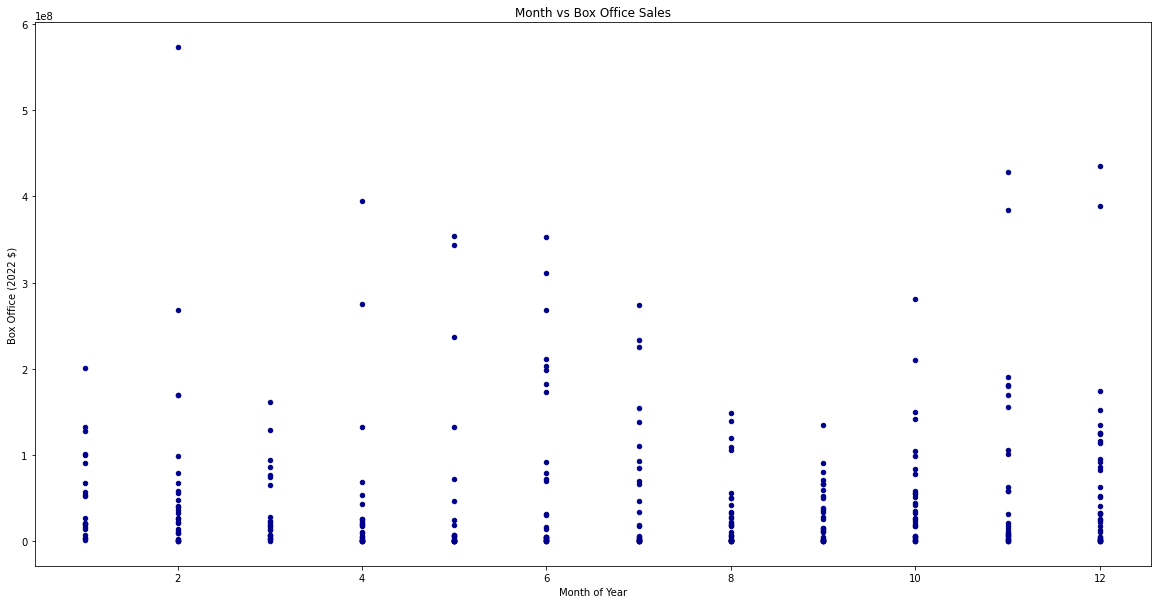

In [14]:
# Try Month vs Sales scatter
ax2 = clean_info.plot.scatter(x='month',y='box2022',c='DarkBlue')
ax2.set_title('Month vs Box Office Sales')
ax2.set_xlabel('Month of Year')
ax2.set_ylabel('Box Office (2022 $)')
plt.show()

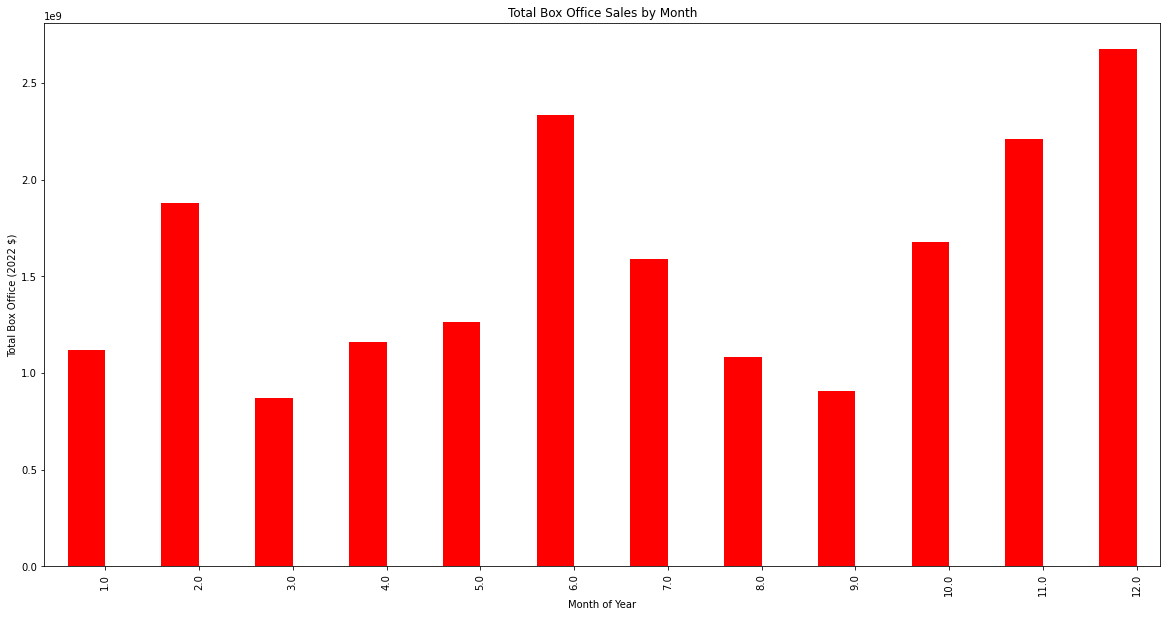

In [15]:
# Try Total Box office by Month of Year
# visualize total box office sales by genre
tot_mo = clean_info[['month','box2022']].groupby('month').sum()
plt.rcParams['figure.figsize'] = (20, 10)
fig = plt.figure() # Create matplotlib figure
ax3 = fig.add_subplot() # Create matplotlib axes
tot_mo.box2022.plot(kind='bar', color='red', ax=ax3, width=width, position=1)
ax3.set_title('Total Box Office Sales by Month')
ax3.set_xlabel('Month of Year')
ax3.set_ylabel('Total Box Office (2022 $)')
plt.show()

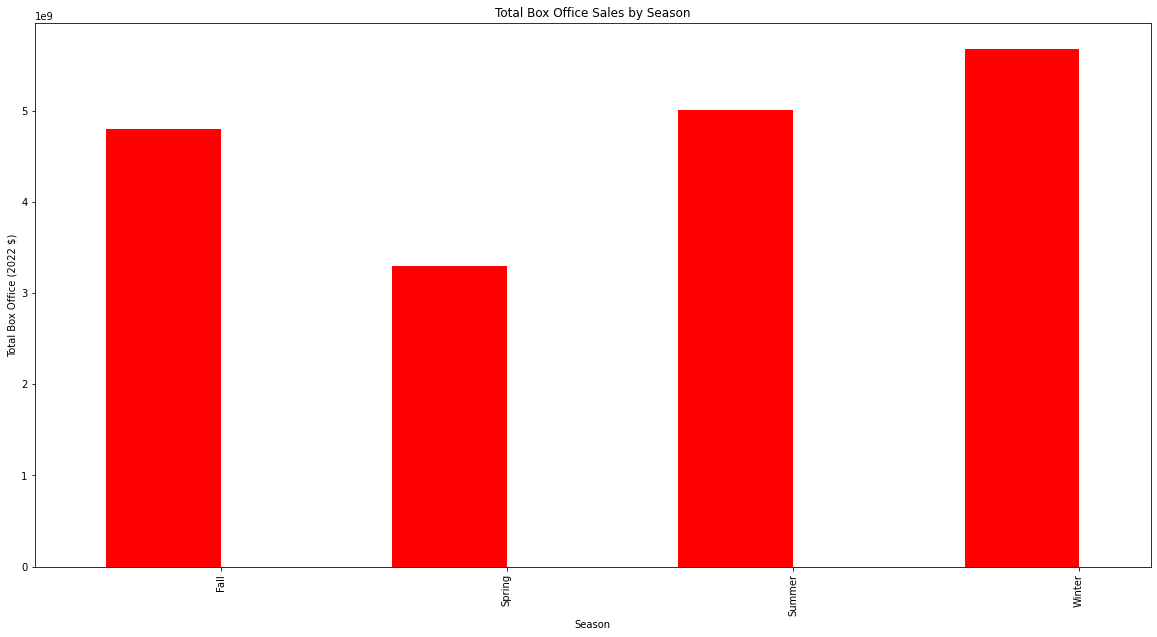

In [16]:
# Try Total Box office by Season of Year
# visualize total box office sales by genre
tot_season = clean_info[['season','box2022']].groupby('season').sum()
plt.rcParams['figure.figsize'] = (20, 10)
fig = plt.figure() # Create matplotlib figure
ax4 = fig.add_subplot() # Create matplotlib axes
tot_season.box2022.plot(kind='bar', color='red', ax=ax4, width=width, position=1)
ax4.set_title('Total Box Office Sales by Season')
ax4.set_xlabel('Season')
ax4.set_ylabel('Total Box Office (2022 $)')
plt.show()